In [1]:
from cil.utilities import dataexample
from cil.processors import PhaseRetriever, Filter
from cil.utilities.display import show2D

from cil.recon import FDK, FBP
from tomopy.prep.phase import retrieve_phase
import numpy as np

import matplotlib.pyplot as plt 

This notebook contains some examples and comparisons of using the Paganin phase retrieval methods in CIL 
- `PhaseRetriever.Paganin()` and 
- `Filter.low_pass_Paganin()`

##### Parallel beam data

In [2]:
delta = 1
beta = 0.01
propagation_distance = 0.3
pixel_size=10e-6
energy = 40000

In [3]:
# Get data and perform reconstruction without phase retrieval
data = dataexample.SIMULATED_PARALLEL_BEAM_DATA.get()
data.reorder(order='tigre')
data_abs = -1*data.log()
ig = data.geometry.get_ImageGeometry()
fbp =  FBP(data_abs, ig)
recon = fbp.run(verbose=0)

In [4]:
# Run phase retrieval on the raw data and reconstruct
processor = PhaseRetriever.Paganin(delta=delta, beta=beta, energy=energy, pixel_size=pixel_size, propagation_distance = propagation_distance)
processor.set_input(data)
thickness = processor.get_output()
fbp =  FBP(thickness, ig)
recon_thickness = fbp.run(verbose=0)

# calculate mu to get recon_attenuation with the same scaling as the original image
mu = (4*np.pi*beta)/(processor.wavelength)
attenuation = thickness*mu
fbp =  FBP(attenuation, ig)
recon_attenuation = fbp.run(verbose=0)

100%|██████████| 300/300 [00:00<00:00, 901.18it/s]


In [5]:
# Run Filter.low_pass_Paganin on the absorption data and reconstruct
processor = Filter.low_pass_Paganin(delta_beta=delta/beta, energy=energy, pixel_size=pixel_size, propagation_distance=propagation_distance)
processor.set_input(data_abs)
filtered_image = processor.get_output()
fbp =  FBP(filtered_image, ig)
recon_filter = fbp.run(verbose=0)

100%|██████████| 300/300 [00:00<00:00, 2393.15it/s]


In [6]:
# For comparison run Tomopy phase retreival with raw data, then convert to absorption and reconstruct
tomopy_alpha = (1/(delta/beta))/(4*np.pi**2)
data_tomopy = data.copy()
data_tmp = retrieve_phase(data.array, pixel_size=100*pixel_size, dist=propagation_distance*100, energy=energy/1000, alpha=tomopy_alpha)
data_tomopy.fill(data_tmp)
data_tomopy = -1*data_tomopy.log()
ig = data_tomopy.geometry.get_ImageGeometry()
fbp =  FBP(data_tomopy, ig)
recon_tomopy = fbp.run(verbose=0)

In [7]:
# And also run Tomopy phase retreival with absorption data and reconstruct
tomopy_alpha = (1/(delta/beta))/(4*np.pi**2)
data_tomopy_abs = data_abs.copy()
data_tmp = retrieve_phase(data_abs.array, pixel_size=100*pixel_size, dist=propagation_distance*100, energy=energy/1000, alpha=tomopy_alpha)
data_tomopy_abs.fill(data_tmp)
ig = data_tomopy_abs.geometry.get_ImageGeometry()
fbp =  FBP(data_tomopy_abs, ig)
recon_tomopy_abs = fbp.run(verbose=0)

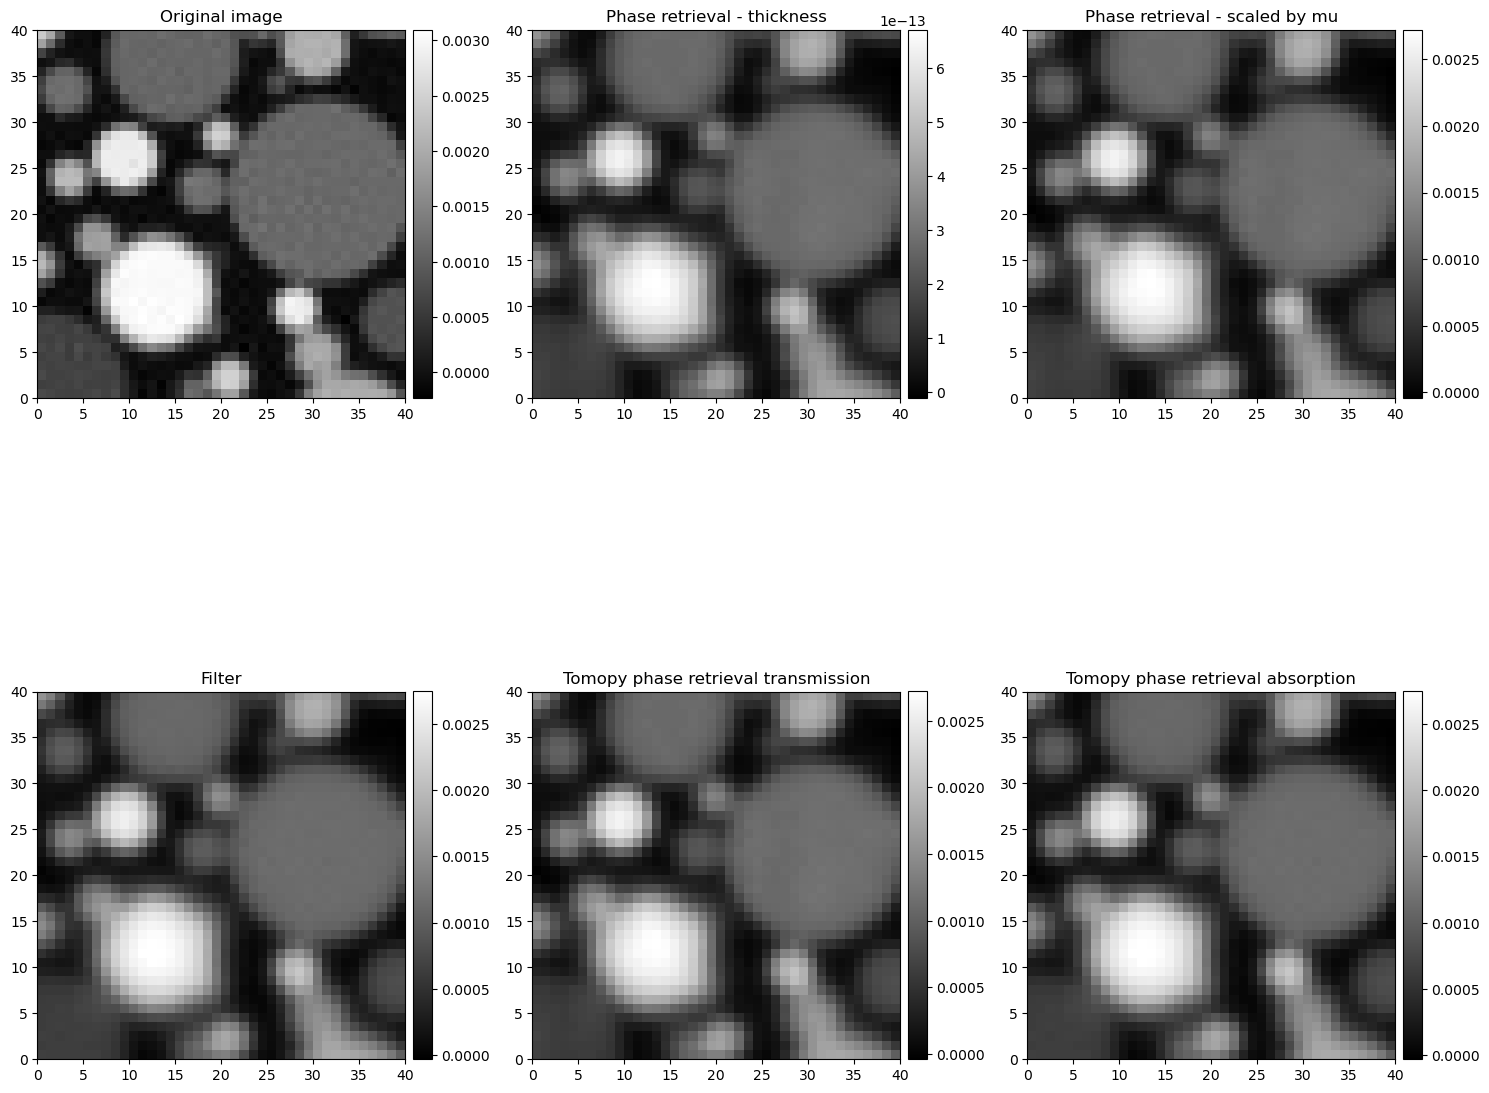

In [8]:
# Compare
# show2D([data_abs, thickness, filtered_image, data_tomopy, data_tomopy_abs], title=['Original image', 'Phase retrieval', 'Filter', 'Tomopy phase retrieval', 'Tomopy phase retrieval absorption'])
# show2D([recon, recon_thickness, recon_filter, recon_tomopy, recon_tomopy_abs], title=['Original image', 'Phase retrieval', 'Filter', 'Tomopy phase retrieval', 'Tomopy phase retrieval absorption'])
show2D([recon.array[67,50:90,50:90], recon_thickness.array[67,50:90,50:90], recon_attenuation.array[67,50:90,50:90], recon_filter.array[67,50:90,50:90], recon_tomopy.array[67,50:90,50:90], recon_tomopy_abs.array[67,50:90,50:90]],
title=['Original image', 'Phase retrieval - thickness', 'Phase retrieval - scaled by mu', 'Filter', 'Tomopy phase retrieval transmission', 'Tomopy phase retrieval absorption'], num_cols=3)

Comparing a cross-section, we can see that all methods blur the original image and improve signal to noise. The scaled phase retrieval in CIL matches the Tomopy method performed on transmission data and the filter in CIL matches the Tomopy method performed on absorption data

Text(0, 0.5, 'Intensity')

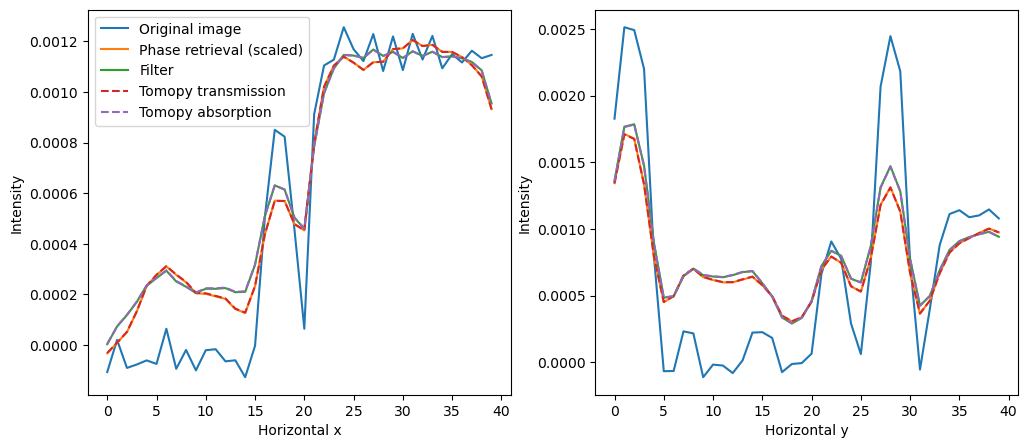

In [9]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
ax = axs[0]
ax.plot(recon.array[67,70,50:90])
ax.plot(recon_attenuation.array[67,70,50:90])
ax.plot(recon_filter.array[67,70,50:90])
ax.plot(recon_tomopy.array[67,70,50:90],'--')
ax.plot(recon_tomopy_abs.array[67,70,50:90],'--')

ax.set_xlabel('Horizontal x')
ax.set_ylabel('Intensity')
ax.legend(['Original image', 'Phase retrieval (scaled)', 'Filter', 'Tomopy transmission', 'Tomopy absorption'])

ax = axs[1]
ax.plot(recon.array[67,50:90,70])
ax.plot(recon_attenuation.array[67,50:90,70])
ax.plot(recon_filter.array[67,50:90,70])
ax.plot(recon_tomopy.array[67,50:90,70],'--')
ax.plot(recon_tomopy_abs.array[67,50:90,70],'--')

ax.set_xlabel('Horizontal y')
ax.set_ylabel('Intensity')

##### Cone beam data

In [10]:
delta = 1
beta = 0.01
propagation_distance = 0.3
pixel_size=10e-6
energy = 40000

With cone beam data, the magnification $M$ has an effect on the phase retrieval\
$ T = -\frac{1}{\mu}\ln(F^{-1}\frac{F(M^2 I_{norm}(x,y,z=\Delta))}{1+\frac{\Delta\lambda\delta}{4\pi\beta}(k_x^2+k_y^2)/M})$\
The $M^2$ on top means sometimes we get a number larger than 1 inside the $\ln$

In [11]:
# Get data and perform reconstruction without phase retrieval
data = dataexample.SIMULATED_CONE_BEAM_DATA.get()
print(data.geometry.magnification)
data.reorder(order='tigre')
data_abs = -1*data.log()
ig = data.geometry.get_ImageGeometry()
fdk =  FDK(data_abs, ig)
recon = fdk.run(verbose=0)

4.0


In [12]:
# Run phase retrieval on the raw data and reconstruct
processor = PhaseRetriever.Paganin(delta=delta, beta=beta,pixel_size=pixel_size, propagation_distance = propagation_distance)
processor.set_input(data)
thickness = processor.get_output()
fdk =  FDK(thickness, ig)
recon_thickness = fdk.run(verbose=0)
# calculate mu to get recon_attenuation with the same scaling as the original image
mu = (4*np.pi*beta)/(processor.wavelength)
attenuation = thickness*mu
fdk =  FDK(attenuation, ig)
recon_attenuation = fdk.run(verbose=0)

100%|██████████| 300/300 [00:00<00:00, 894.26it/s]


In [13]:
# Run Filter.low_pass_Paganin on the absorption data and reconstruct
processor = Filter.low_pass_Paganin(delta_beta=delta/beta, pixel_size=pixel_size, propagation_distance=propagation_distance)
processor.set_input(data_abs)
filtered_image = processor.get_output()
fdk =  FDK(filtered_image, ig)
recon_filter = fdk.run(verbose=0)

100%|██████████| 300/300 [00:00<00:00, 2456.94it/s]


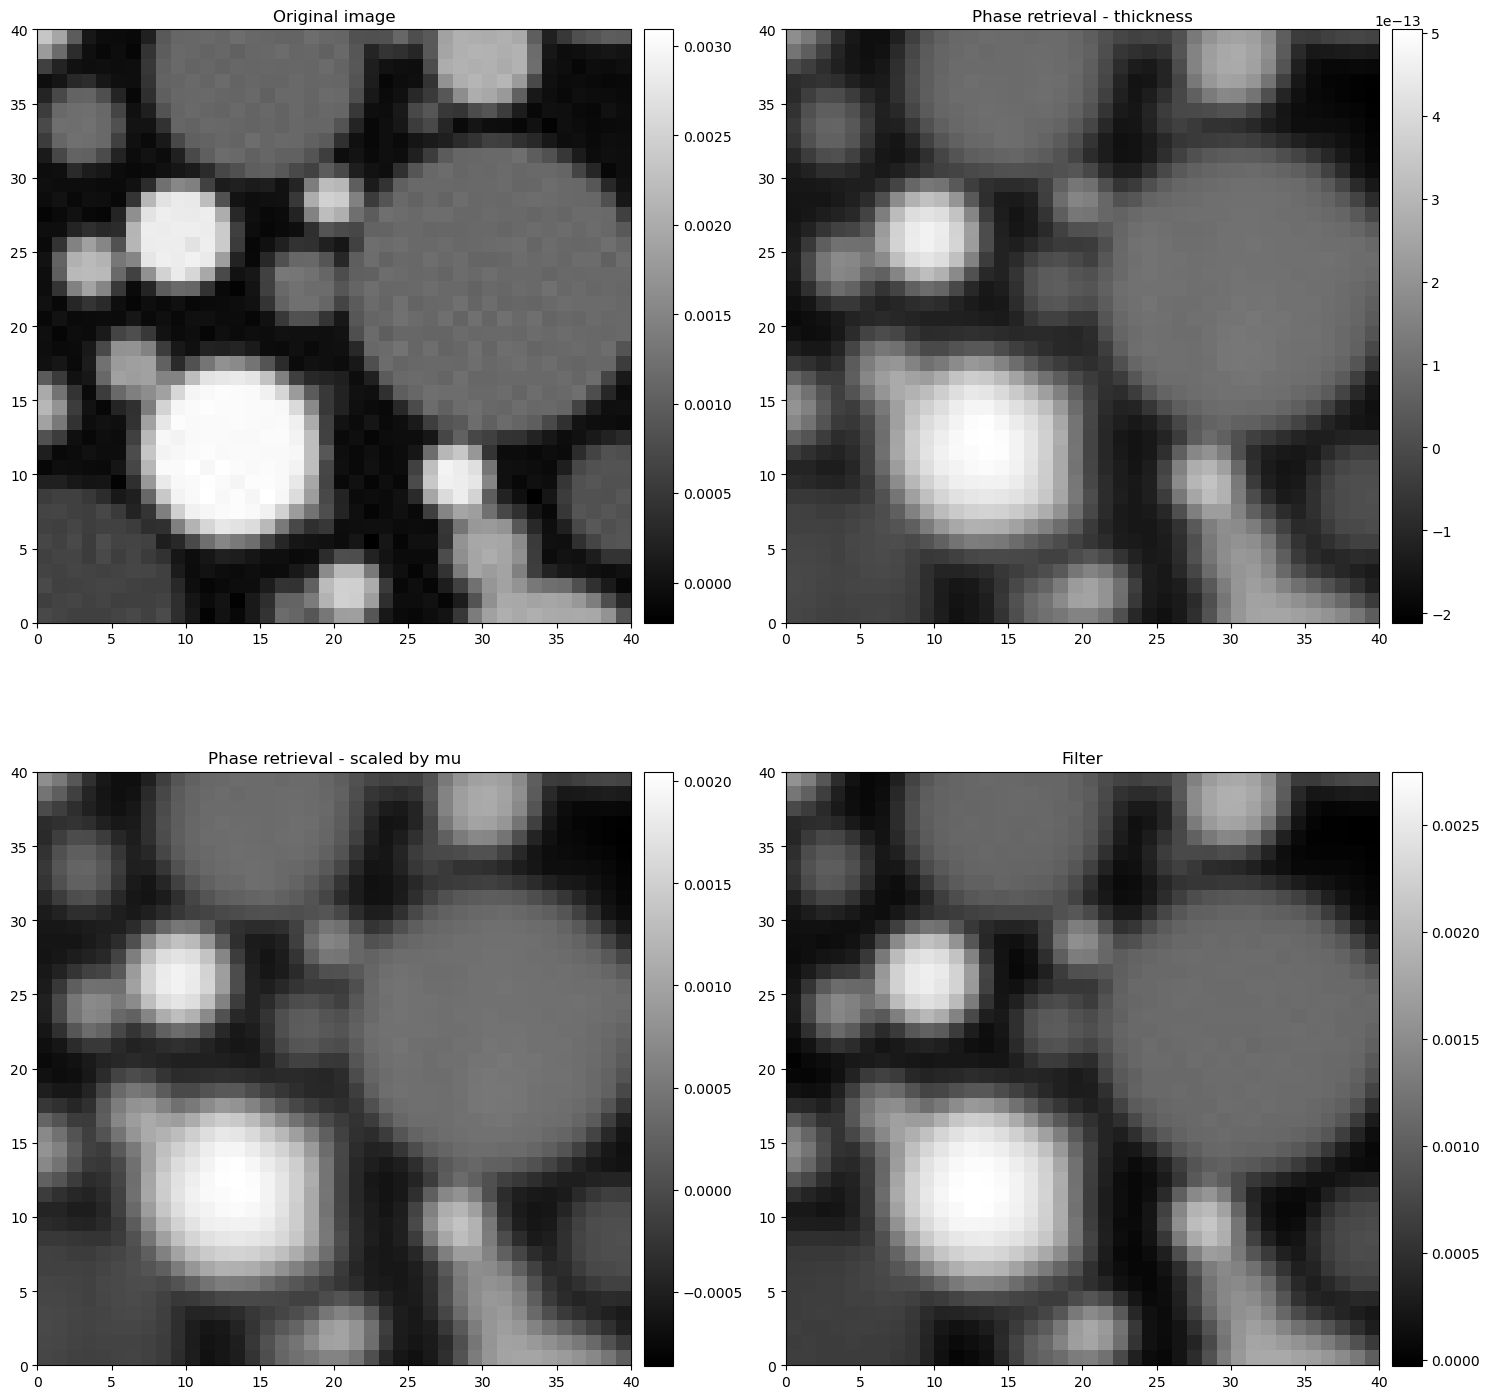

In [14]:
# Compare
show2D([recon.array[67,50:90,50:90], recon_thickness.array[67,50:90,50:90], recon_attenuation.array[67,50:90,50:90], recon_filter.array[67,50:90,50:90]],
title=['Original image', 'Phase retrieval - thickness', 'Phase retrieval - scaled by mu', 'Filter'])

Comparing a cross-section, we can see that both methods blur the original image and improve signal to noise. The phase retrieval method becomes negative because of the values > 1 in the negative log

Text(0, 0.5, 'Intensity')

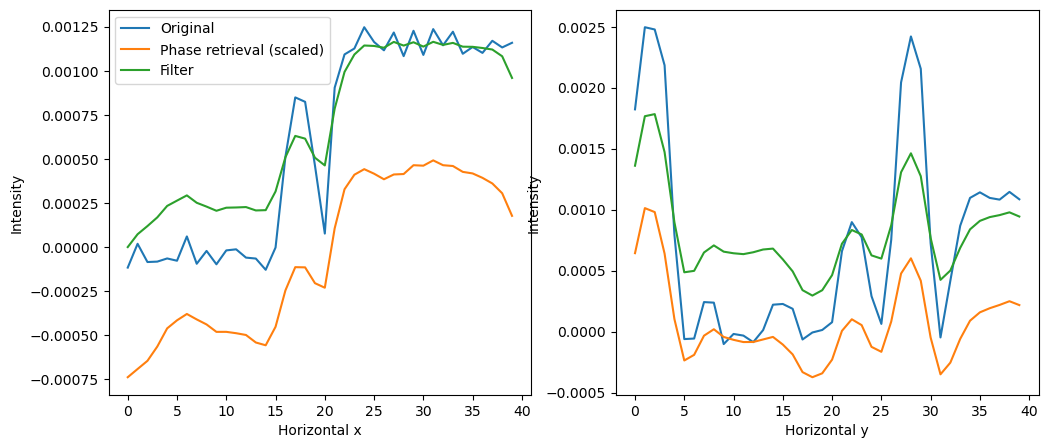

In [15]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
ax = axs[0]
ax.plot(recon.array[67,70,50:90])
ax.plot(recon_attenuation.array[67,70,50:90])
ax.plot(recon_filter.array[67,70,50:90])

ax.set_xlabel('Horizontal x')
ax.set_ylabel('Intensity')
ax.legend(['Original', 'Phase retrieval (scaled)', 'Filter'])

ax = axs[1]
ax.plot(recon.array[67,50:90,70])
ax.plot(recon_attenuation.array[67,50:90,70])
ax.plot(recon_filter.array[67,50:90,70])

ax.set_xlabel('Horizontal y')
ax.set_ylabel('Intensity')

##### Generalised Paganin method

The generalised Paganin method is implemented in CIL following the description in https://iopscience.iop.org/article/10.1088/2040-8986/abbab9 \
When features in the image are close to the Nyquist frequency of the system, a more generalised form of the Pagnin filter can be used which preserves these high frequency features while still boosting SNR. This may have a similar effect to applying an unsharp mask after the normal Paganin phase retrieval. 

In [16]:
delta = 1
beta = 0.01
propagation_distance = 0.3
pixel_size=10e-6
energy = 40000

In [17]:
# Get data and perform reconstruction without phase retrieval
data = dataexample.SIMULATED_PARALLEL_BEAM_DATA.get()
data.reorder(order='tigre')
data_abs = -1*data.log()
ig = data.geometry.get_ImageGeometry()
fbp =  FBP(data_abs, ig)
recon = fbp.run(verbose=0)

In [18]:
# Run phase retrieval on the raw data and reconstruct
processor = PhaseRetriever.Paganin(delta=delta, beta=beta, energy=energy, pixel_size=pixel_size, propagation_distance = propagation_distance)
processor.set_input(data)
thickness = processor.get_output()
fbp =  FBP(thickness, ig)
recon_thickness = fbp.run(verbose=0)

# calculate mu to get recon_attenuation with the same scaling as the original image
mu = (4*np.pi*beta)/(processor.wavelength)
attenuation = thickness*mu
fbp =  FBP(attenuation, ig)
recon_attenuation = fbp.run(verbose=0)

100%|██████████| 300/300 [00:00<00:00, 916.17it/s]


In [19]:
# Run phase retrieval on the raw data and reconstruct using the generalised Paganin method
processor = PhaseRetriever.Paganin(delta=delta, beta=beta, energy=energy, pixel_size=pixel_size, propagation_distance = propagation_distance,
                                   filter_type='generalised_paganin_method')
processor.set_input(data)
thickness_GPM = processor.get_output()
fbp =  FBP(thickness_GPM, ig)
recon_thickness_GPM = fbp.run(verbose=0)

# calculate mu to get recon_attenuation with the same scaling as the original image
mu = (4*np.pi*beta)/(processor.wavelength)
attenuation_GPM = thickness_GPM*mu
fbp =  FBP(attenuation_GPM, ig)
recon_attenuation_GPM = fbp.run(verbose=0)

100%|██████████| 300/300 [00:00<00:00, 913.52it/s]


Text(0, 0.5, 'Intensity')

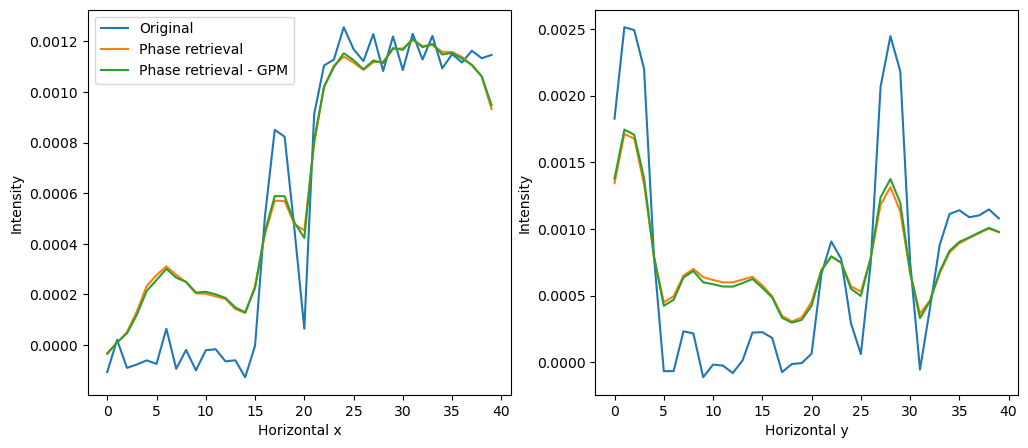

In [20]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
ax = axs[0]
ax.plot(recon.array[67,70,50:90])
ax.plot(recon_attenuation.array[67,70,50:90])
ax.plot(recon_attenuation_GPM.array[67,70,50:90])

ax.set_xlabel('Horizontal x')
ax.set_ylabel('Intensity')
ax.legend(['Original', 'Phase retrieval', 'Phase retrieval - GPM'])

ax = axs[1]
ax.plot(recon.array[67,50:90,70])
ax.plot(recon_attenuation.array[67,50:90,70])
ax.plot(recon_attenuation_GPM.array[67,50:90,70])

ax.set_xlabel('Horizontal y')
ax.set_ylabel('Intensity')

#### TomoBank example

This example uses dataset tomo_00068 from TomoBank https://tomobank.readthedocs.io/en/latest/source/data/docs.data.phasecontrast.html#wet-sample which can be retrieved using:\
`wget https://g-a0400.fd635.8443.data.globus.org/tomo_00068/tomo_00068.h5`

In [21]:
from cil.io.utilities import HDF5_utilities
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.utilities.display import show2D, show_geometry
from cil.processors import TransmissionAbsorptionConverter, Padder, RingRemover, CentreOfRotationCorrector

In [22]:
filename = 'tomo_00068.h5'
# HDF5_utilities.print_metadata(filename=filename, group='/')
data = HDF5_utilities.read(filename=filename, dset_path='/exchange/data')

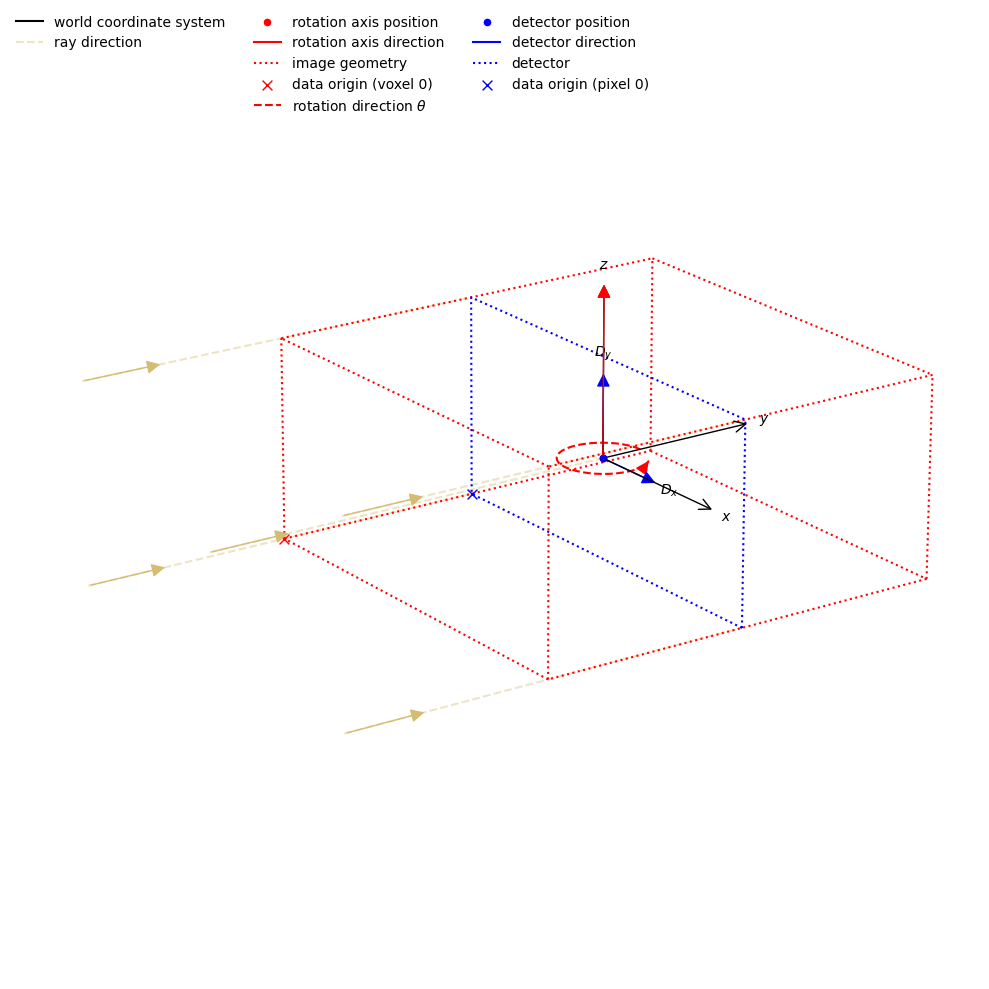

In [23]:
angles = HDF5_utilities.read(filename=filename, dset_path='/exchange/theta')
ag = AcquisitionGeometry.create_Parallel3D().set_panel([np.shape(data)[2],np.shape(data)[1]]).set_angles(angles)
show_geometry(ag)

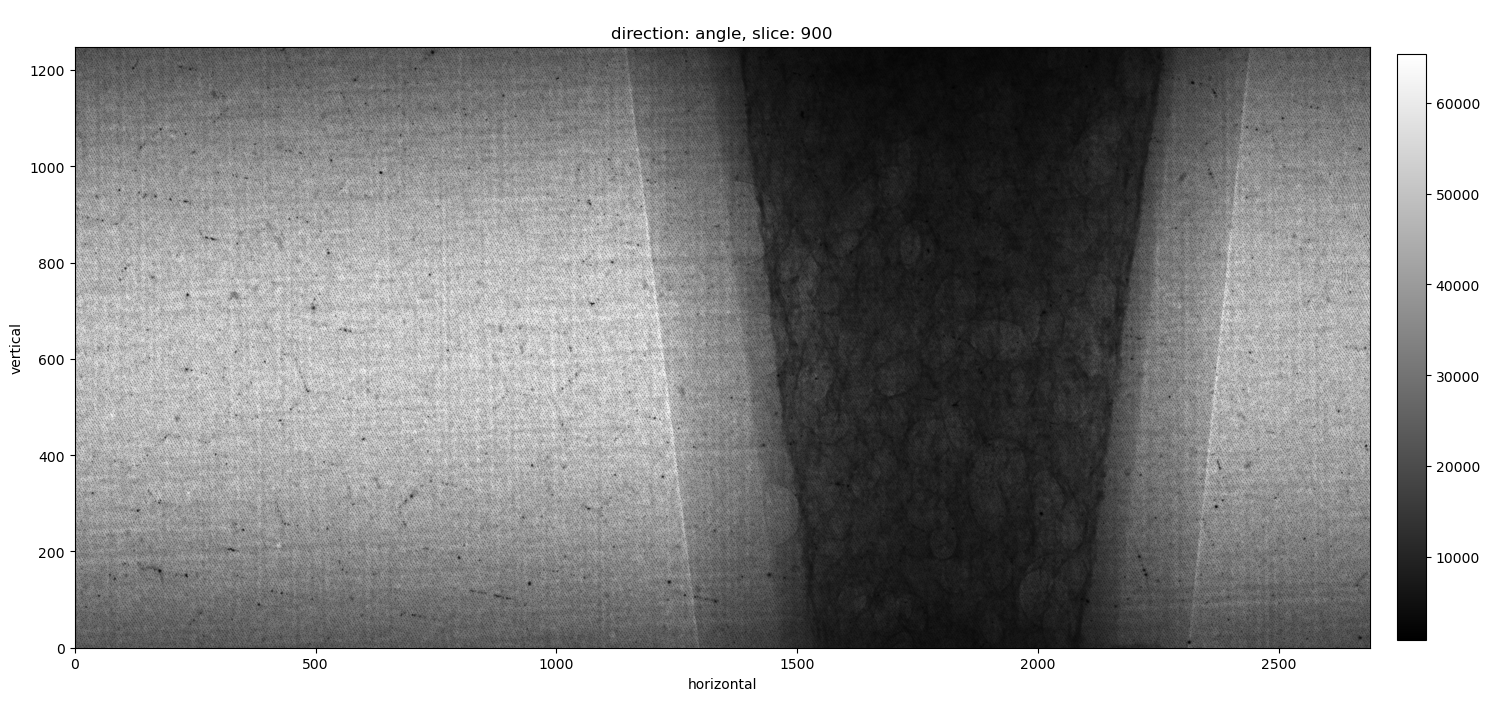

In [24]:
data = AcquisitionData(data, deep_copy=False, geometry = ag)
data.reorder(order='tigre')
show2D(data)

In [25]:
vertical_slice = 900

In [26]:
# Run phase retrieval on a slice of the raw data
data_slice = data.get_slice(vertical=vertical_slice)

# parameters from https://tomobank.readthedocs.io/en/latest/source/data/docs.data.phasecontrast.html#wet-sample
delta = 1
beta = 1e-6
energy = 14000
pixel_size = 4.1e-6
propagation_distance = 150e-3
processor = PhaseRetriever.Paganin(delta=delta, beta=beta, energy=energy, pixel_size=pixel_size, propagation_distance = propagation_distance)
processor.set_input(data_slice)
thickness = processor.get_output()

# calculate mu to get recon_attenuation with the same scaling as the original image
mu = (4*np.pi*beta)/(processor.wavelength)
data_phase = thickness*mu

 84%|████████▎ | 1505/1800 [00:00<00:00, 1876.32it/s]

100%|██████████| 1800/1800 [00:00<00:00, 1866.06it/s]


In [27]:
# for comparison just run TransmissionAbsorptionConverter on the same slice
data_slice = data.get_slice(vertical=vertical_slice)

processor = TransmissionAbsorptionConverter()
processor.set_input(data_slice)
processor.get_output(out=data_slice)

Finish Ring Remover
Finish Ring Remover


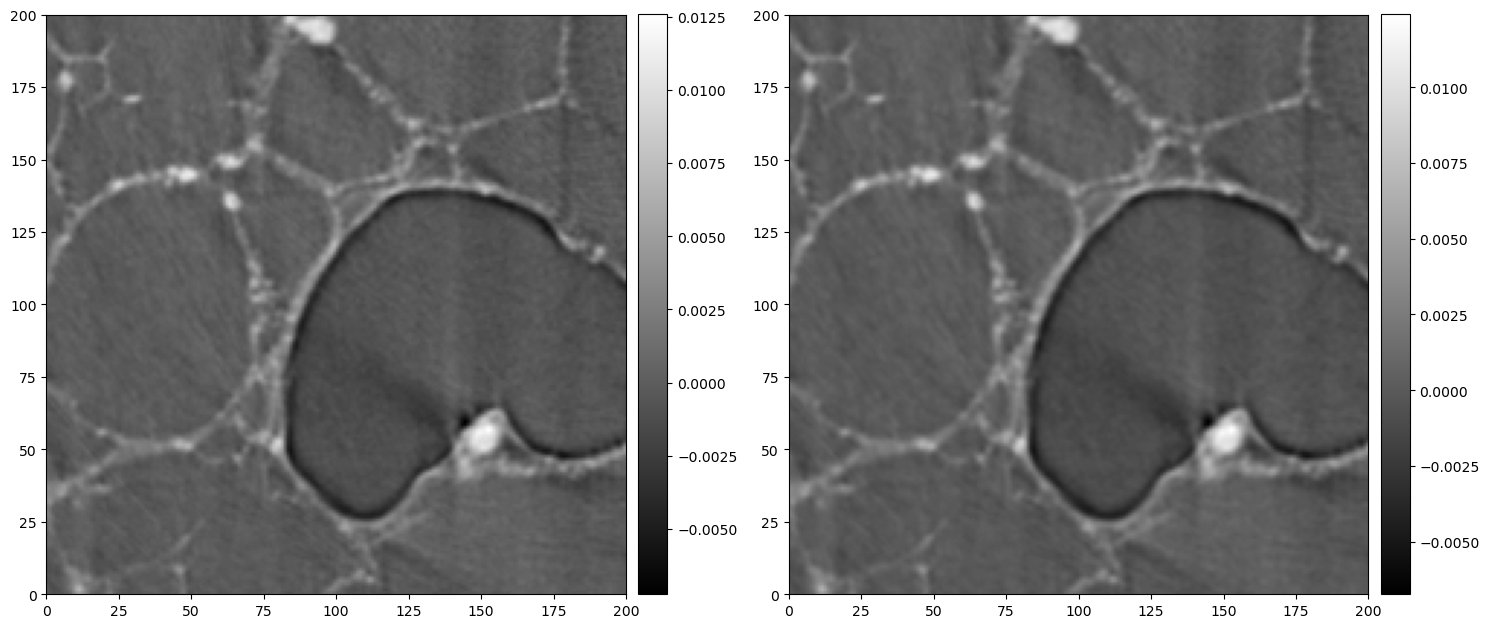

In [28]:
# perform some extra processing steps on both datasets
ig = data_slice.geometry.get_ImageGeometry()
padsize = 1000
data_slice = Padder.linear_ramp(pad_width={'horizontal': padsize}, end_values=0)(data_slice)
data_phase = Padder.linear_ramp(pad_width={'horizontal': padsize}, end_values=0)(data_phase)

data_slice.geometry.set_centre_of_rotation(1463.5-(data.shape[2]/2), distance_units='pixels')
data_phase.geometry.set_centre_of_rotation(1463.5-(data.shape[2]/2), distance_units='pixels')

N_decompositions = 20
wavelet_filter_name = 'db20'
sigma = 5.5

processor = RingRemover(N_decompositions, wavelet_filter_name, sigma) 
processor.set_input(data_slice)
data_slice = processor.get_output()

processor = RingRemover(N_decompositions, wavelet_filter_name, sigma) 
processor.set_input(data_phase)
data_phase = processor.get_output()

fbp =  FBP(data_slice, ig)
recon = fbp.run(verbose=0)

fbp =  FBP(data_phase, ig)
recon_phase = fbp.run(verbose=0)

# show2D([recon, recon_phase])
show2D([recon.array[1100:1300,1100:1300], recon_phase.array[1100:1300,1100:1300]])

Text(0, 0.5, 'Intensity')

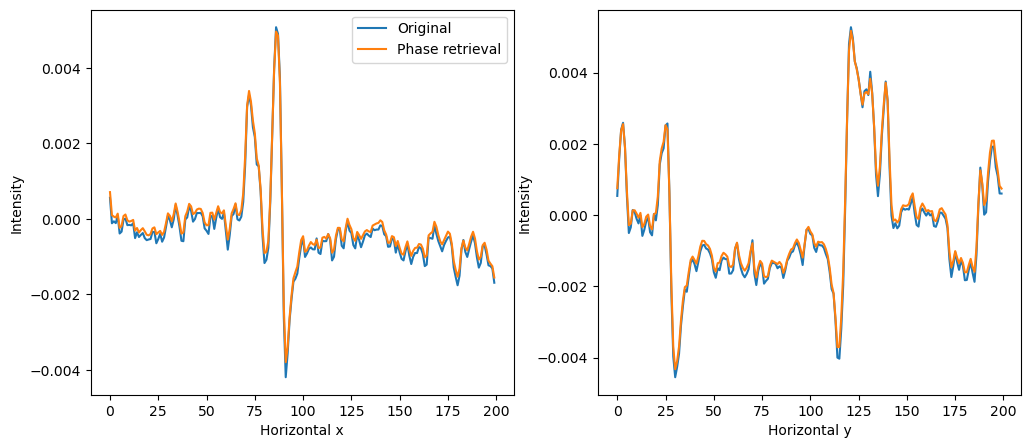

In [29]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
ax = axs[0]
x = 1200
ax.plot(recon.array[x,1100:1300])
ax.plot(recon_phase.array[x,1100:1300])

ax.set_xlabel('Horizontal x')
ax.set_ylabel('Intensity')
ax.legend(['Original', 'Phase retrieval'])

ax = axs[1]
y = 1200
ax.plot(recon.array[1100:1300,1200])
ax.plot(recon_phase.array[1100:1300,1200])

ax.set_xlabel('Horizontal y')
ax.set_ylabel('Intensity')